In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('/Users/vimu/Documents/Data Science/SDS/Github/TimeSeriesAnalysis/Data/Energy_consumption.csv',index_col= "Timestamp",parse_dates=True)

In [6]:
columns_to_remove = [
    'Humidity', 'SquareFootage', 
    'HVACUsage', 'LightingUsage', 'RenewableEnergy', 'DayOfWeek', 'Holiday'
]

df_cleaned = df.drop(columns=columns_to_remove, errors='ignore')

In [7]:
import numpy as np

def create_lagged_features(df, lookback=10):
    X, y = [], []

    for i in range(lookback, len(df)):
        X.append(df.iloc[i - lookback:i].values)        # past 10 rows
        y.append(df.iloc[i]['EnergyConsumption'])       # target is next Energy value

    return np.array(X), np.array(y)

# apply the function
X, y = create_lagged_features(df_cleaned, lookback=10)

print(f"X shape: {X.shape}")  # (samples, timesteps, features)
print(f"y shape: {y.shape}")  # (samples,)

X shape: (990, 10, 3)
y shape: (990,)


In [8]:
X

array([[[25.13943344,  5.        , 75.3643734 ],
        [27.73165052,  1.        , 83.40185495],
        [28.70427686,  2.        , 78.27088774],
        ...,
        [23.18284425,  8.        , 74.13190618],
        [25.39199937,  6.        , 78.20623587],
        [22.21254942,  1.        , 77.9922137 ]],

       [[27.73165052,  1.        , 83.40185495],
        [28.70427686,  2.        , 78.27088774],
        [20.08046949,  1.        , 56.51985049],
        ...,
        [25.39199937,  6.        , 78.20623587],
        [22.21254942,  1.        , 77.9922137 ],
        [28.06481358,  2.        , 82.27443448]],

       [[28.70427686,  2.        , 78.27088774],
        [20.08046949,  1.        , 56.51985049],
        [23.09735926,  9.        , 70.81173247],
        ...,
        [22.21254942,  1.        , 77.9922137 ],
        [28.06481358,  2.        , 82.27443448],
        [23.42254626,  6.        , 73.2786695 ]],

       ...,

       [[23.90781959,  4.        , 73.62123677],
        [29

In [10]:
from sklearn.preprocessing import MinMaxScaler

# reshape X to 2D for scaling
n_samples, timesteps, n_features = X.shape
X_reshaped = X.reshape((n_samples * timesteps, n_features))

# create scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# fit_transform input and target
X_scaled = scaler_X.fit_transform(X_reshaped)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# reshape X back to 3D
X_scaled = X_scaled.reshape((n_samples, timesteps, n_features))

print(f"X_scaled shape: {X_scaled.shape}")
print(f"y_scaled shape: {y_scaled.shape}")

X_scaled shape: (990, 10, 3)
y_scaled shape: (990, 1)


In [11]:
y_scaled

array([[0.63153068],
       [0.43570596],
       [0.67224529],
       [0.14713883],
       [0.60777582],
       [0.45317711],
       [0.78878172],
       [0.42686299],
       [0.66691463],
       [0.62724543],
       [0.89192283],
       [0.13951683],
       [0.36945465],
       [0.54706379],
       [0.75272075],
       [0.42811254],
       [0.72719603],
       [0.59097573],
       [0.23833988],
       [0.45489859],
       [0.60486739],
       [0.37104255],
       [0.63174744],
       [0.14332659],
       [0.63652879],
       [0.64258935],
       [0.46608274],
       [0.73198607],
       [0.55029029],
       [0.52168709],
       [0.44564291],
       [0.83983332],
       [0.43727407],
       [0.28165928],
       [0.53525584],
       [0.82107031],
       [0.62375158],
       [0.36922369],
       [0.772141  ],
       [0.50702746],
       [0.19138419],
       [0.19022695],
       [0.59186171],
       [0.24935742],
       [0.84045495],
       [0.35763511],
       [0.23047878],
       [0.338

In [12]:
# Determine split index
split_index = int(0.8 * len(X_scaled))

# Split X and y
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (792, 10, 3)
X_test shape: (198, 10, 3)
y_train shape: (792, 1)
y_test shape: (198, 1)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

window_size = 10
# Define the model
model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(window_size, X_train.shape[2])))
model.add(Dense(1))  # Predicting single output (next energy consumption)

# Compile the model
model.compile(optimizer='adam', loss='mse')
model.summary()

/Users/vimu/Documents/Data Science/SDS/Github/TimeSeriesAnalysis/venv310_arm/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,473 (68.25 KB)

 Trainable params: 17,473 (68.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
df_cleaned.columns

Index(['Temperature', 'Occupancy', 'EnergyConsumption'], dtype='object')

In [14]:
print("X_train shape:", X_train.shape[2])

X_train shape: 3


In [15]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2449 - val_loss: 0.0444
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0383 - val_loss: 0.0392
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0319 - val_loss: 0.0393
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0346 - val_loss: 0.0389
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0339 - val_loss: 0.0389
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0324 - val_loss: 0.0385
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0297 - val_loss: 0.0385
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0322 - val_loss: 0.0384
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0320 - val_loss: 0.0382
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0326 - val_loss: 0.0379
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0333 - val_loss: 0.0386
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0310 - val_lo

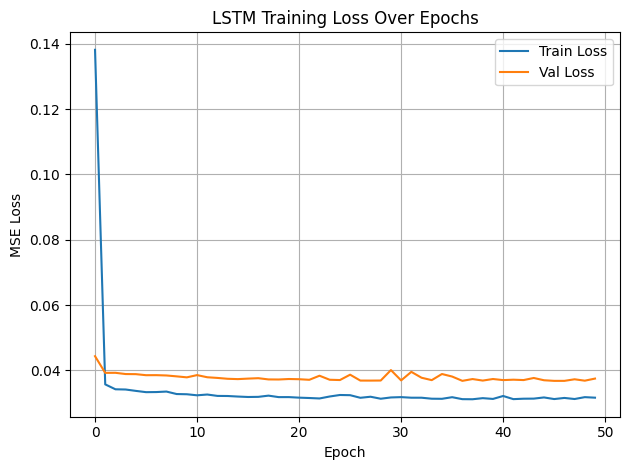

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
y_pred_scaled = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [18]:
# Inverse transform predictions and true values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

In [19]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"LSTM Model RMSE: {rmse:.2f}")

LSTM Model RMSE: 8.19


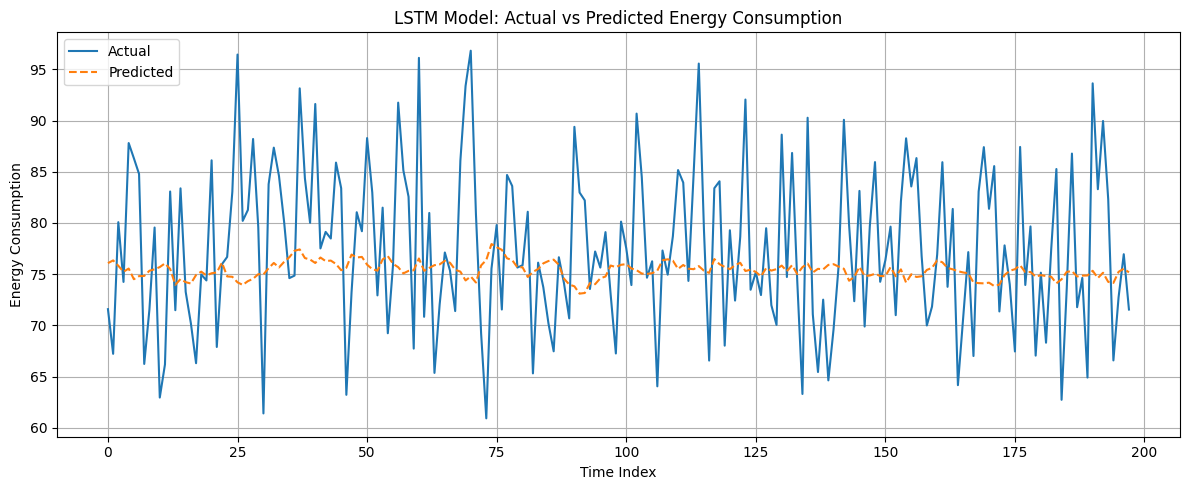

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.title('LSTM Model: Actual vs Predicted Energy Consumption')
plt.xlabel('Time Index')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()